# XGBoost

### 1. Introdução ao XGBoost

#### 1.1 Oque é XGBoost?

O Extreme Gradient Boosting (XGBoost) é um modelo que utiliza decision trees em sequência. Enquanto a Random Forest usa várias árvores em bagging, ou seja, treina todas as árvores de forma independente e combina suas previsões ao final, o boosting utiliza as árvores em sequência, em que as árvores são usadas para prever o erro de modelos anteriores. Isso lembra o tema do projeto, Delta Learning, porém com no boosting sendo feito sucessivas vezes.

Em Machine Learning, a regressão linear é um dos modelos mais simples de previsão de dados. Porém, ela pode sofrer com o Underfit e Overfit. O que acontece é que a regressão linear faz previsões calculando um polinômio para tentar representar o resultado, porém, para representar com grande acurácia os dados de treino, é necessário um polinômio de grau alto, que pode gerar resultados melhores para os dados de treino, mas piores para os demais, ou seja overfit (super ajustado). Veja na imagem abaixo:
<div align="center">
    <img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/bb/4e/6-1_sequential-ensemble-learning_boosting.component.l.ts=1739197330108.png/content/adobe-cms/br/pt/think/topics/xgboost/jcr:content/root/table_of_contents/body-article-8/image" alt="Fern vs Ehre" width="800">
</div>

https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/bb/4e/6-1_sequential-ensemble-learning_boosting.component.l.ts=1739197330108.png/content/adobe-cms/br/pt/think/topics/xgboost/jcr:content/root/table_of_contents/body-article-8/image

#### 1.2 Matemática do XGBoost

Primeiramente, um modelo simples prevê um resultado $y_i$ para os inputs $x_i$, utilizando um algoritmo, como para o modelo linear:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...$$

$$\hat{y} = \sum_{j} \theta_jx_{ij}$$

Além disso, para o treino do modelo teremos a denominada objective function, que mede o quão bem o modelo se comporta. 

$$ obj(\theta) = L(\theta) + \Omega(\theta)

Essa função é tal que L é a training loss function, que mede o quão bom são os resultados previstos em comparação com o que deveria prever. Um exemplo muito usado é o MSE:

$$L(\theta) = \sum_{i} (y_i - \hat{y}_i)^2$$

Enquanto $\Omega$ é o termo de regularização, que controla a complexidade do modelo, evitando o Overfitting.

Agora, sobre as Decision Trees, o XGBoost é um ensemble delas. O ensemble de árvores de regressão e classificação (CART) difere das Decision Trees ao introduzir um valor real para cada folha, o que será usado para a otimização. Veja a imagem como exemplo:

<div align="center">
    <img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" alt="Fern vs Ehre" width="800">
</div>

https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png

Veja que as duas árvores são usadas em conjunto somadas para obter a previsão, ou seja:

$$
\hat{y}_i = \sum_{k=1}^{K} f_k(x_i), f_k \in F
$$

Com K o número de árvores, F todo o espaço de CARTs e $f_k$ a função nesse espaço. Dessa forma, a função objetiva é definida como:

$$
obj(\theta) = \sum_{i}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \omega(f_k)
$$

Com $\omega(f_k)$ a complexidade da árvore $f_k$.

Agora, enfim, chegando especificamente ao boosting, definimos nossa função objetivo a ser otimizada:

$$
obj(\theta) = \sum_{i}^{n} l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^{t} \omega(f_k)
$$

Em que t é o número de árvores no sensemble. Como dito anteriormente, cada passo utilizará uma só arvore.

### 2. Treino de Modelo

Primeiro importamos as bibliotecas e o dataframe

In [1]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from optuna import create_study
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
import matplotlib.pyplot as plt

C:\Users\matheus25022\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../dataset_processing/xtb_dataset.csv')
df

,Dipole,E_HOMO,E_LUMO,gap_HOMO-LUMO,ZPE,H,U,U0,G,Delta
0,0.727,-10.6203,-2.7950,-7.8253,0.154214,-27.917739,-27.918683,-28.080950,-27.959630,-12.397982
1,1.905,-10.4336,-2.2949,-8.1387,0.199866,-28.104404,-28.105348,-28.313524,-28.146070,-12.165407
2,4.475,-10.5746,-6.9494,-3.6252,0.120064,-27.272560,-27.273504,-27.400818,-27.312535,-13.078113
3,2.100,-9.8173,-5.5314,-4.2859,0.177677,-27.068399,-27.069343,-27.254803,-27.108720,-13.224129
4,0.872,-9.9722,-6.6172,-3.3550,0.133244,-24.148876,-24.149821,-24.292155,-24.192788,-16.186776
...,...,...,...,...,...,...,...,...,...,...
129152,4.710,-11.3840,-7.8335,-3.5505,0.121817,-26.808903,-26.809847,-26.939965,-26.851229,-13.538966
129153,4.996,-10.8793,-7.1097,-3.7696,0.141742,-28.278349,-28.279293,-28.428099,-28.317523,-12.050832
129154,3.973,-10.9497,-7.7346,-3.2151,0.124894,-24.819326,-24.820270,-24.952019,-24.858199,-15.526912
129155,0.918,-10.2869,-1.8611,-8.4258,0.195977,-30.002576,-30.003520,-30.208931,-30.047056,-10.270000


In [ ]:
X = df.drop("Delta", axis=1)
y = df["Delta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=27)

Agora, fazemos uma função para gerar as combinações de parâmetros a serem usados pelo Optuna

In [5]:
def suggest_xgb_params(trial):
    params = {}

    params['booster'] = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    params['objective'] = 'reg:squarederror'
    params['verbosity'] = 0
    params['random_state'] = trial.number
    params['n_jobs'] = 1

    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)

    params['n_estimators'] = trial.suggest_int('n_estimators', 100, 3000)  # usar early stopping/pruner

    params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
    params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.4, 1.0)
    params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.4, 1.0)
    params['colsample_bynode'] = trial.suggest_float('colsample_bynode', 0.4, 1.0)

    params['min_child_weight'] = trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True)
    params['gamma'] = trial.suggest_float('gamma', 1e-8, 10.0, log=True)

    params['reg_alpha'] = trial.suggest_float('reg_alpha', 1e-8, 100.0, log=True)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-8, 100.0, log=True)

    params['max_delta_step'] = trial.suggest_int('max_delta_step', 0, 10)

    params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if params['grow_policy'] == 'depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 3, 12)
        # max_leaves is ignored for depthwise, ensure not set (or set large)
        params['max_leaves'] = 0
    else:  # lossguide
        params['max_depth'] = 0  # ignored by lossguide
        params['max_leaves'] = trial.suggest_int('max_leaves', 8, 1024)

    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.3)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.3)
    else:
        # ensure DART params not present for gbtree (optional: they are simply ignored)
        params['sample_type'] = 'uniform'
        params['normalize_type'] = 'tree'
        params['rate_drop'] = 0.0
        params['skip_drop'] = 0.0

    return params

Instanciamos o modelo

In [6]:
def inst_xgboost(trial):
    parametros = suggest_xgb_params(trial)

    normalizar = trial.suggest_categorical('normalizar', [None, 'stds', 'pca', 'limiar', 'rfe'])
    if normalizar == 'stds':
        modelo = make_pipeline(StandardScaler(), XGBRegressor(**parametros))
    elif normalizar == "pca":
        # Definindo o número de componentes a serem mantidas
        components = trial.suggest_int("pca_components", 2, 9)
        modelo = make_pipeline(
            StandardScaler(),
            PCA(components),
            XGBRegressor(**parametros))
    elif normalizar == "limiar":
        # Definindo o Limiar a ser utilizado
        threshold = trial.suggest_float("variance_threshold", 0, 0.1)
        modelo = make_pipeline(
            StandardScaler(),
            VarianceThreshold(threshold),
            XGBRegressor(**parametros)
        )
    elif normalizar == "rfe": 
        # Criando o modelo para parametro do RFE
        estimator = RandomForestRegressor()
        # Definindo o número de atributos a serem mantidos
        n_features_to_select = trial.suggest_int("rfe_features", 2, 9)
        modelo = make_pipeline(
            StandardScaler(),
            RFE(estimator=estimator, n_features_to_select=n_features_to_select),
            XGBRegressor(**parametros)
        )
    else:
        modelo = XGBRegressor(**parametros)

    return modelo

Criar função objetivo com cross validation e parada com MedianPrunner

In [7]:
def funcao_objetivo(trial, X, y, num_folds, instanciador, random_state=42):
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)

    modelo = instanciador(trial)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    fold_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_arr)):
        X_train, X_val = X_arr[train_idx], X_arr[val_idx]
        y_train, y_val = y_arr[train_idx], y_arr[val_idx]

        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_val)

        # Compatível com todas as versões do sklearn:
        mse = mean_squared_error(y_val, preds)
        rmse = float(np.sqrt(mse))
        fold_scores.append(rmse)

        trial.report(rmse, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned()

    return float(np.mean(fold_scores))


Implementação do Optuna

In [8]:
def rodar_optuna(nome_estudo, X, y, instanciador, num_folds=5, n_trials=1000):
    study = create_study(
        direction='minimize',
        study_name=nome_estudo,
        storage=f'sqlite:///{nome_estudo}.db',
        load_if_exists=True,
        pruner=MedianPruner()
    )

    def objetivo_parcial(trial):
        return funcao_objetivo(trial, X, y, num_folds, instanciador)

    study.optimize(objetivo_parcial, n_trials=n_trials, show_progress_bar=True, n_jobs=3)
    return study



In [ ]:
study_en = rodar_optuna('elas_xtb', X_train, y_train, inst_xgboost)

Usando-se o melhor modelo de acordo com o Optuna nos dados separados para teste

In [10]:
model = XGBRegressor(booster="gbtree", 
                     colsample_bylevel=0.7444692303677609, 
                     colsample_bynode=0.94070330903296,
                     colsample_bytree=0.8576468748597981,
                     gamma=0.0000029265344647141457,
                     grow_policy="lossguide",
                     learning_rate=0.17248401306681566,
                     max_delta_step=10,
                     max_leaves=653,
                     min_child_weight=0.013131713175532052,
                     n_estimators=1284,
                     reg_alpha=0.04646885526155054,
                     reg_lambda=7.634253975485113,
                     subsample=0.6768760639340133)

pipe_final = make_pipeline(
    StandardScaler(),
    model
)

cv = KFold(n_splits=10, shuffle=True, random_state=27)

# Validação cruzada para o Pipeline
cv_pipe = -cross_val_score(
    pipe_final,
    X_test,
    y_test,
    cv=cv,
    scoring='neg_root_mean_squared_error'
)

print(f'RMSE Médio (CV) - Pipeline XGBoost: {cv_pipe.mean()}')

RMSE Médio (CV) - Pipeline XGBoost: 0.09450821862373894


Usando-se o melhor modelo para o Optuna para todo o dataset

In [9]:
model = XGBRegressor(booster="gbtree", 
                     colsample_bylevel=0.7444692303677609, 
                     colsample_bynode=0.94070330903296,
                     colsample_bytree=0.8576468748597981,
                     gamma=0.0000029265344647141457,
                     grow_policy="lossguide",
                     learning_rate=0.17248401306681566,
                     max_delta_step=10,
                     max_leaves=653,
                     min_child_weight=0.013131713175532052,
                     n_estimators=1284,
                     reg_alpha=0.04646885526155054,
                     reg_lambda=7.634253975485113,
                     subsample=0.6768760639340133)

pipe_final = make_pipeline(
    StandardScaler(),
    model
)

cv = KFold(n_splits=10, shuffle=True, random_state=27)

# Validação cruzada para o Pipeline
cv_pipe = -cross_val_score(
    pipe_final,
    X,
    y,
    cv=cv,
    scoring='neg_root_mean_squared_error'
)

print(f'RMSE Médio (CV) - Pipeline XGBoost: {cv_pipe.mean()}')

RMSE Médio (CV) - Pipeline XGBoost: 0.1009608257332442


### 3. Resultados

Após feitos 276 trials, analisemos o obtido pelo Optuna Dashboard

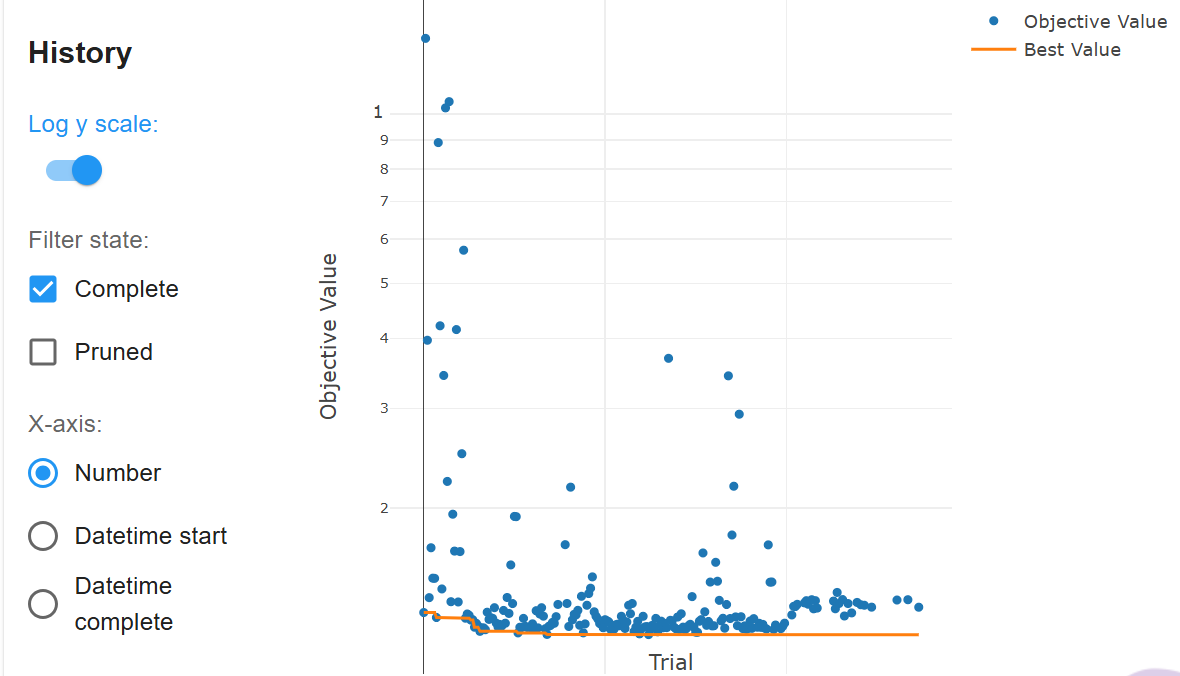

In [11]:
from IPython.display import Image
Image(filename='../images/xgb_trials.png', height=200, width=700)

É visível que o XGBoost é um modelo com grande constância de resultados, pois mesmo mudando os hiperparâmetros 276 vezes, quase todos obtiveram RMSE parecidos, com somente aproximadamente 1% dos testes conseguindo RMSE em uma ordem de grandeza diferente. Dentre os casos analisados, o trial 124 obteve o melhor resultado, com 0.11908037786999448. Após 152 testes não obtivemos um RMSE melhor, sendo um bom indicativo que resultados melhores após teriam overfitting. Porém o XGBoost também apresentou-se como um ótimo modelo para prevenir overfitting, pois após mais de 250 casos, ele não aparenta ter o apresentado com intensidade.

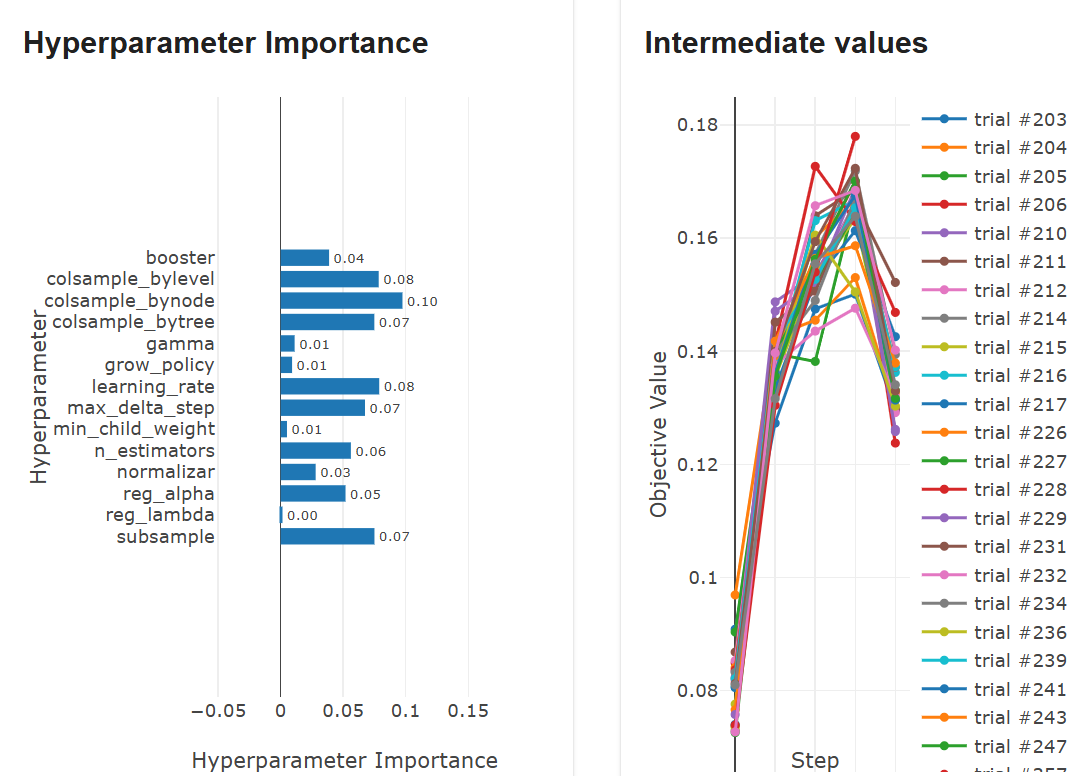

In [14]:
Image(filename='../images/xgb_parameters.png', height=200, width=700)

Além disso, quase todos os parâmetros do XGBoost se apresentaram como importantes ao modelo, porém como visto anteriormente, o modelo consegue ótimos resultados mesmo sem grande personalização.

### 4. Interpretabilidade via SHAP

#### 4.1 O que é o *SHAP*

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

#### 4.2 Relação com a interpretabilidade de modelos

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

### 5. Usando o SHAP

#### 5.1 Módulo necessário

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

In [ ]:
import shap

#### 5.2 Avaliando o melhor modelo

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, precisamos carregá-lo a partir do arquivo de estudo utilizando a função `load_study`.

**Observação importante:** O *SHAP* não aceita um pipeline completo como entrada, ele requer um modelo final ou uma função de predição. Por isso, criamos um *trial* “falso” (`FixedTrial`) com os melhores hiperparâmetros para instanciar o pipeline vencedor.

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`ElasticNet`), mas também inclui todas as etapas de pré-processamento do pipeline, como `StandardScaler`, `RFE`, `PCA` ou `VarianceThreshold`. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


In [ ]:
from optuna import load_study
# --- Carregar estudo Optuna ---
NOME_DO_ESTUDO = "xgboost_xtb_finaleTrue2"
ARQUIVO_DB = "xgboost_xtb.db"

study = load_study(study_name=NOME_DO_ESTUDO, storage=f"sqlite:///{ARQUIVO_DB}")

# Melhor trial
melhor_trial = study.best_trial
melhores_params = melhor_trial.params

print(f"Melhor valor objetivo: {melhor_trial.value}")
print(f"Número do trial: {melhor_trial.number}")
print("Melhores hiperparâmetros:")
for key, val in melhor_trial.params.items():
    print(f"  {key}: {val}")

Melhor valor objetivo: 0.11908037786999448
Número do trial: 124
Melhores hiperparâmetros:
  booster: gbtree
  learning_rate: 0.17248401306681566
  n_estimators: 1284
  subsample: 0.6768760639340133
  colsample_bytree: 0.8576468748597981
  colsample_bylevel: 0.7444692303677609
  colsample_bynode: 0.94070330903296
  min_child_weight: 0.013131713175532052
  gamma: 2.9265344647141457e-06
  reg_alpha: 0.04646885526155054
  reg_lambda: 7.634253975485113
  max_delta_step: 10
  grow_policy: lossguide
  max_leaves: 653
  normalizar: None


Perceba que estudo encontrou melhor desempenho quando o parâmetro que continha os métodos de *featuring engenniring* (*normalizar*) não foi aplicado. Logo, podemos criar um modelo diretamente a partir dos melhores hiperparâmetros encontrados.

Para esse modelo, utilizamos o `PermutationExplainer`

O `PermutationExplainer` é um método do SHAP que avalia a **importância das features** com base em permutações dos dados de entrada. Ele calcula os valores de SHAP estimando como a previsão do modelo muda quando **os valores de cada feature são embaralhados**, mantendo as demais constantes.

Eele funciona da seguinte forma:

1. **Entrada:** Recebe um modelo treinado (`model`) e um conjunto de dados de referência (`data`) que representa o comportamento típico das features.
2. **Permutação das features:** Para cada feature:
   - Os valores são permutados aleatoriamente.
   - O modelo faz previsões com essa feature embaralhada.
   - A mudança na previsão indica a **contribuição daquela feature** para o resultado.
3. **Cálculo dos valores SHAP:** Com base nas diferenças de previsões, o `PermutationExplainer` estima os **valores de Shapley** para cada feature, mostrando quanto cada uma contribui para a saída do modelo.
4. **Vantagem:** Funciona com **qualquer tipo de modelo** (tree-based, linear, redes neurais, etc.), mesmo sem acesso interno aos coeficientes.
5. **Desvantagem:** Pode ser mais **lento**, especialmente com muitos dados ou features, pois realiza múltiplas permutações.

In [ ]:
import shap

# Refazer o modelo resetando base_score
melhor_modelo = XGBRegressor(booster="gbtree", 
                     colsample_bylevel=0.7444692303677609, 
                     colsample_bynode=0.94070330903296,
                     colsample_bytree=0.8576468748597981,
                     gamma=0.0000029265344647141457,
                     grow_policy="lossguide",
                     learning_rate=0.17248401306681566,
                     max_delta_step=10,
                     max_leaves=653,
                     min_child_weight=0.013131713175532052,
                     n_estimators=1284,
                     reg_alpha=0.04646885526155054,
                     reg_lambda=7.634253975485113,
                     subsample=0.6768760639340133,
                     base_score=0.5)  # Adicionar base_score explícito
melhor_modelo.fit(X_train, y_train)

# Se as soluções acima não funcionarem, use Permutation Explainer
explainer = shap.PermutationExplainer(melhor_modelo.predict, X_train)
shap_values = explainer.shap_values(X_test)

PermutationExplainer explainer: 116243it [4:41:34,  6.88it/s]                              


---

As valores *shap* foram calculados, agora vamos analizá-los!

---

#### 5.3 Summary plot

C:\Users\edelio25024\AppData\Local\Temp\ipykernel_38844\4090070440.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


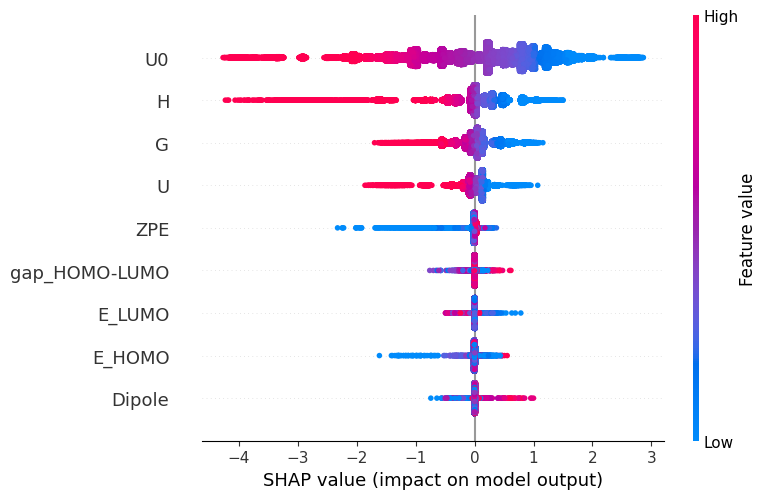

In [ ]:
# --- Plotar resumo SHAP ---
shap.summary_plot(shap_values, X_test)

O gráfico acima é um **summary plot do SHAP**, que mostra como cada feature influencia a predição do modelo. Cada ponto representa uma amostra, e a posição no eixo x indica o efeito da feature na predição. A cor do ponto indica o valor da feature para aquela amostra, do azul (baixo) ao rosa/vermelho (alto).

``Features mais importantes``

- **U0 (energia interna)**:  
  - É a feature mais determinante no modelo.  
  - Valores altos de U0 (rosa) tendem a **diminuir a predição**, enquanto valores baixos (azul) aumentam a predição.  
  - **Insight científico**: isso sugere que sistemas com energia interna mais baixa estão associados a maior valor previsto pelo modelo, possivelmente refletindo estabilidade energética.

- **H (entalpia), G (energia de Gibbs), U (energia interna)**:  
  - Todas apresentam impactos fortes e relativamente consistentes.  
  - Tendência: valores altos reduzem a predição, valores baixos aumentam.  
  - **Insight científico**: essas grandezas termodinâmicas estão inter-relacionadas; sistemas mais estáveis (menor H, G, U) favorecem maior predição, indicando que o modelo captura aspectos fundamentais de estabilidade molecular.

- **ZPE (energia do ponto zero)**:  
  - Impacto moderado, geralmente negativo para valores altos.  
  - **Insight científico**: moléculas com ZPE mais alta contribuem menos para a predição, possivelmente devido a maior energia vibracional que aumenta a instabilidade relativa.

- **gap_HOMO-LUMO, E_HOMO, E_LUMO**:  
  - Impacto menor, efeitos mistos dependendo da amostra.  
  - **Insight científico**: essas variáveis estão relacionadas à reatividade eletrônica; o modelo indica que a estabilidade eletrônica influencia a predição, mas de forma mais sutil.

- **Dipole (momento dipolar)**:  
  - Impacto pequeno, mas valores altos tendem a aumentar a predição.  
  - **Insight científico**: moléculas mais polares podem estar associadas a maiores valores previstos pelo modelo, refletindo interações intermoleculares mais fortes.

``Observações gerais``

- O modelo prioriza **grandezas termodinâmicas** (U0, H, G, U) como principais determinantes.  
- **Propriedades eletrônicas** (HOMO-LUMO, E_HOMO, E_LUMO) têm influência menor, mas ainda relevante para certas amostras.  
- **Polaridade** (Dipole) exerce um efeito mais específico, sugerindo que moléculas polares têm comportamentos distintos no modelo.  
- A dispersão dos pontos mostra que o impacto das features não é uniforme para todas as amostras, permitindo capturar variações químicas sutis.

---

> Em resumo, o SHAP plot confirma que o modelo aprende relações químico-físicas coerentes: estabilidade termodinâmica e polaridade molecular são fatores-chave na predição, enquanto propriedades eletrônicas modulam o efeito de forma mais sutil.



### 5.4 Bar plot

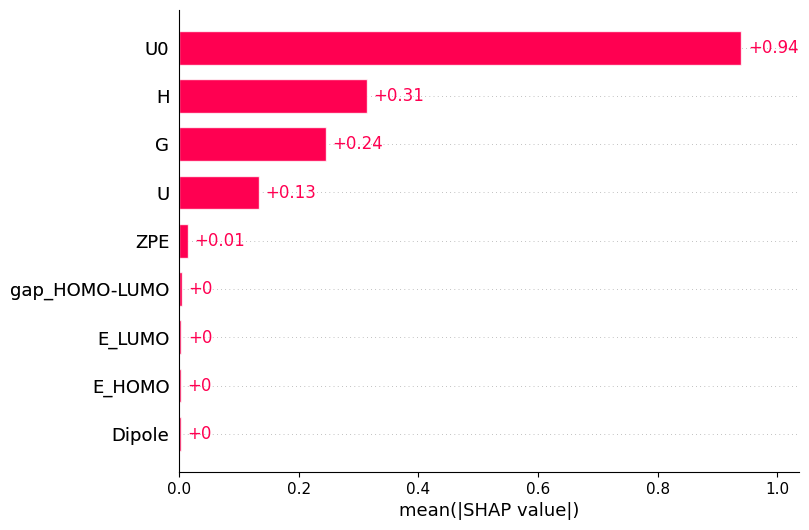

In [ ]:

# shap_values já é um numpy.ndarray
shap_values_exp = shap.Explanation(
    values=shap_values,        # passa o array direto
    data=X_test,               # seu DataFrame de teste
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

O gráfico de barras apresenta a **importância global das variáveis** de acordo com o valor médio absoluto dos *SHAP values*.  
Ele indica, em média, **quanto cada variável contribui para alterar as previsões do modelo** — independentemente de aumentar ou diminuir o valor predito.

- O eixo horizontal mostra o valor médio de $|SHAP|$, ou seja, a **intensidade média do impacto**.  
- As variáveis são ordenadas de forma decrescente, destacando as que mais influenciam o modelo.  
- Valores próximos de zero indicam que a *feature* tem pouca ou nenhuma influência sobre as previsões.
  
``Interpretação``

Somente pelo *summary plot* não conseguiríamos ter certeza da importância de cada *feature*, nesse caso. O *bar plot* pode, dessa forma, complementar o que vimos anteriormente, mas agora com a real contribuição de cada atributo dos nossos dados, de maneira quantitativa.

Percebe que, em ordem decrescente de importância, as *features* **U0**, **H**, **G**, **U** foram as mais relevantes para a predição. O **ZPE** teve um pequeno impacto, enquanto que as restantes tiveram influência mínima.

#### 5.5 Waterfall Plot

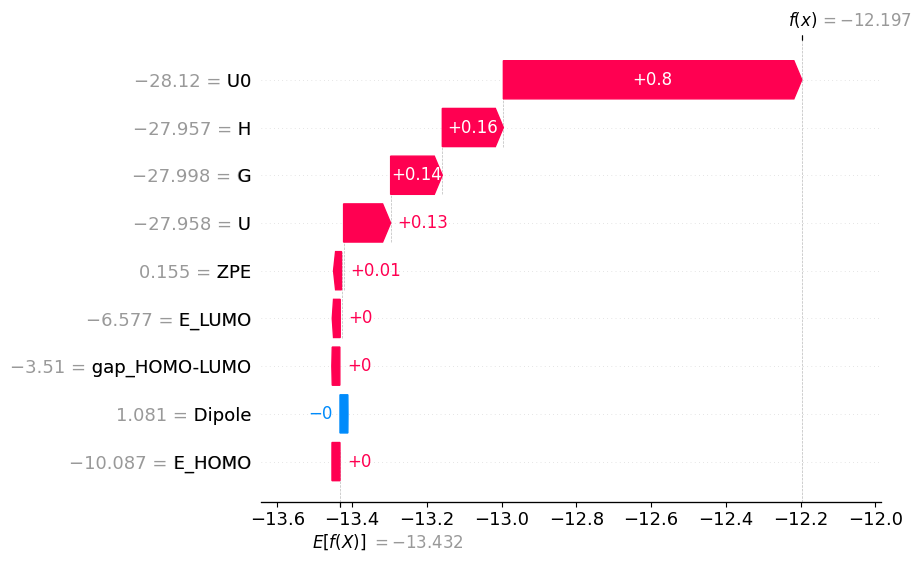

In [ ]:
# Base value manual
base_value = melhor_modelo.predict(X_train).mean()  # média das previsões no conjunto de treino

# Cria o objeto Explanation
shap_values_exp = shap.Explanation(
    values=shap_values,        # array de SHAP
    base_values=base_value,    # agora passa o valor base
    data=X_test,
    feature_names=X_test.columns
)

# Agora funciona no waterfall
shap.plots.waterfall(shap_values_exp[1])


O gráfico *waterfall* detalha **como cada variável contribuiu para uma predição específica** do modelo.  
Partindo da média global das predições $E[f(X)]$, o gráfico mostra passo a passo o efeito de cada *feature* até chegar ao valor final $f(x)$ da amostra analisada.

- As **barras azuis** indicam *features* que **reduzem** a previsão (impacto negativo).  
- As **barras vermelhas** representam *features* que **aumentam** a previsão (impacto positivo).  
- À esquerda, vê-se o valor médio da variável na amostra e sua respectiva contribuição.

**Interpretação:**  
Para essa instância, as variáveis **U0**, **H**, **G** e **U** tiveram forte influência positiva, aumentando o valor final previsto ($f(x) = -16.436$).  
Já as demais variáveis têm impacto quase nulo.  
Assim, o gráfico mostra **como a combinação específica dos valores dessas variáveis levou o modelo a fazer essa predição em particular**, revelando a **explicabilidade local** do modelo.

### 6. Referências

Izbicki and dos Santos - 2020 - Aprendizado de máquina.pdf
